In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2]:
df = pd.read_csv(r"D:\Machine Learning\Projects\Transformer Network\IMDB Dataset.csv\IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Map sentiment to numeric value: positive → 1, negative → 0
df["value"] = df["sentiment"].map({"positive": 1, "negative": 0})

print(df.head())

                                              review sentiment  value
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


In [5]:
df.shape

(50000, 3)

In [6]:
X = df["review"]
y = df["value"]


print(X.head())
print(y.head())


0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object
0    1
1    1
2    1
3    0
4    1
Name: value, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(40000,) (40000,)
(5000,) (5000,)
(5000,) (5000,)


In [8]:
# Using a set to store unique words
words = set()

for raw in df['review']:
    for word in raw.split():  # split text into words by spaces
        words.add(word.lower())  
print(f"Number of unique words: {len(words)}")


Number of unique words: 390931


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define constants
MAX_LEN = 128      
VOCAB_SIZE = 380000  

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text into sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences so they all have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Example sequence:\n{X_train_pad[0]}")
print(f"Vocab size: {len(tokenizer.word_index) + 1}")


Example sequence:
[  198    49    11   802  2161   535   303     2   108  1908  2039  4325
  6551     3   816  4845    13 22580     2 13694   228     2  6191    80
   783    54    53    23   102     5     2    28  2010   103    37    26
    35   120  1131    13    10     7  2367  1191     6   455    49   553
     6    93    34    24    40   917   401 29671    16     2   167     6
  2994    25 38444  4360    21     4  2946    13    46    76   222    74
   127     9    82  3156   196    21   240     3     2   448     8     8
    11   206  4983   145    22    64    28    16 14645    75   366   303
     4    20    19    10   206    27   308    13 65052 43366    15     2
 14999 10162   116   440     3 50894 50895    15     2  1705 11317   616
    71   425   382    11    90   119    49   113]
Vocab size: 112282


In [10]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [11]:
#Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.maxlen = maxlen
        self.d_model = d_model
        self.pos_encoding = self.get_positional_encoding(maxlen, d_model)

    def get_positional_encoding(self, seq_len, d_model):
        positions = np.arange(seq_len)[:, np.newaxis]
        dims = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / np.float32(d_model))
        angle_rads = positions * angle_rates
        pos_encoding = np.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "d_model": self.d_model
        })
        return config


#Multi-Head Attention 
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.Wq = layers.Dense(d_model)
        self.Wk = layers.Dense(d_model)
        self.Wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, [0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        Q = self.split_heads(self.Wq(q), batch_size)
        K = self.split_heads(self.Wk(k), batch_size)
        V = self.split_heads(self.Wv(v), batch_size)
        logits = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        if mask is not None:
            logits += (mask * -1e9)
        weights = tf.nn.softmax(logits, axis=-1)
        attention = tf.matmul(weights, V)
        attention = tf.transpose(attention, [0, 2, 1, 3])
        concat = tf.reshape(attention, (batch_size, -1, self.num_heads * self.depth))
        return self.dense(concat)

#Encoder Block
class EncoderBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training=False, mask=None):
        attn = self.att(x, x, x, mask)
        attn = self.drop1(attn, training=training)
        out1 = self.norm1(x + attn)
        ffn_out = self.ffn(out1)
        ffn_out = self.drop2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

#Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, ff_dim, vocab_size, maxlen, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.vocab_size = vocab_size
        self.maxlen = maxlen
        
        self.embed = layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(maxlen, d_model)
        self.layers_list = [EncoderBlock(d_model, num_heads, ff_dim) for _ in range(num_layers)]

    def call(self, x, training=False, mask=None):
        x = self.embed(x)
        x = self.pos_encoding(x)
        for layer in self.layers_list:
            x = layer(x, training=training, mask=mask)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "vocab_size": self.vocab_size,
            "maxlen": self.maxlen
        })
        return config

# Build Model 
def build_encoder_sentiment(vocab_size, maxlen, num_layers=2, d_model=64, num_heads=2, ff_dim=128):
    inputs = layers.Input(shape=(maxlen,))
    encoder = Encoder(num_layers, d_model, num_heads, ff_dim, vocab_size, maxlen)
    enc_out = encoder(inputs)
    pooled = layers.GlobalAveragePooling1D()(enc_out)  # Global average pooling
    x = layers.Dense(64, activation='relu')(pooled)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [12]:
model = build_encoder_sentiment(20000, MAX_LEN)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 encoder (Encoder)           (None, 128, 64)           1346944   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                             

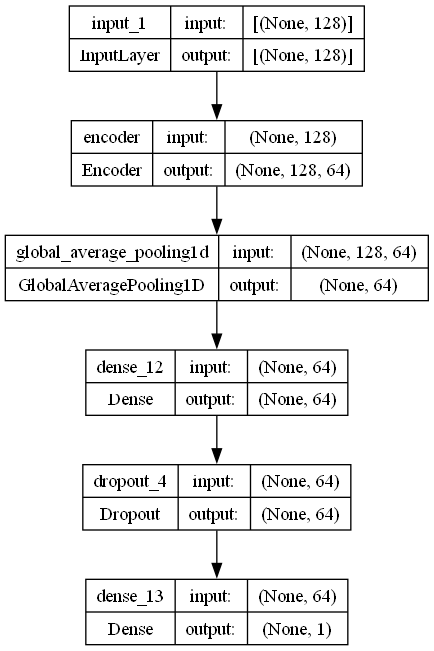

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True 
)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "best_model.h5",           
    monitor="val_accuracy",     
    save_best_only=True,        
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",     
    patience=5,                 
    restore_best_weights=True,  
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",         
    factor=0.5,                
    patience=10,                 
    min_lr=1e-6,               
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]


history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=500,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/500
1250/1250 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5012
Epoch 1: val_accuracy improved from -inf to 0.72520, saving model to best_model.h5
1250/1250 [==============================] - 15s 10ms/step - loss: 0.6952 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 2/500
1246/1250 [============================>.] - ETA: 0s - loss: 0.4718 - accuracy: 0.7458
Epoch 2: val_accuracy improved from 0.72520 to 0.85500, saving model to best_model.h5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.4715 - accuracy: 0.7462 - val_loss: 0.3314 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/500
1247/1250 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8922
Epoch 3: val_accuracy improved from 0.85500 to 0.85920, saving model to best_model.h5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2712 - accuracy: 0.8922 - val_loss: 0.3441 - val_accuracy: 0.8592 - lr: 0.0010
Epoc

In [16]:
#Evaluate Test Accuracy
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

157/157 [==============================] - 1s 7ms/step - loss: 0.3321 - accuracy: 0.8626
Test Accuracy: 0.8626


In [18]:
#Evaluate Validation Accuracy
loss, acc = model.evaluate(X_val_pad, y_val)
print(f"Validation Accuracy: {acc:.4f}")

157/157 [==============================] - 1s 6ms/step - loss: 0.3441 - accuracy: 0.8592
Validation Accuracy: 0.8592


In [17]:
##Evaluate Train Accuracy
loss, acc = model.evaluate(X_train_pad, y_train)
print(f"Train Accuracy: {acc:.4f}")

1250/1250 [==============================] - 8s 6ms/step - loss: 0.1825 - accuracy: 0.9329
Train Accuracy: 0.9329


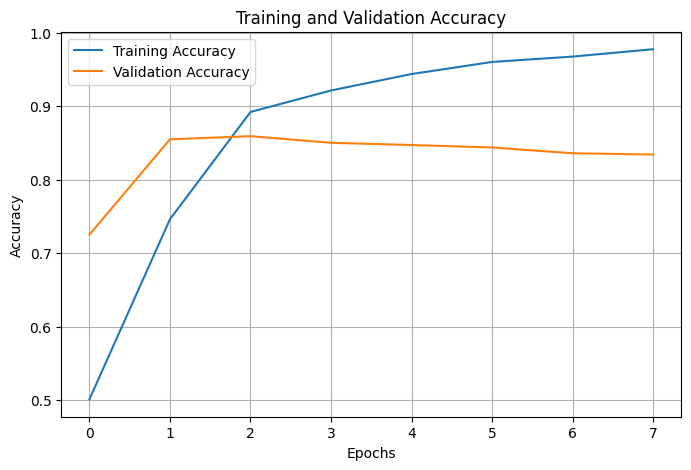

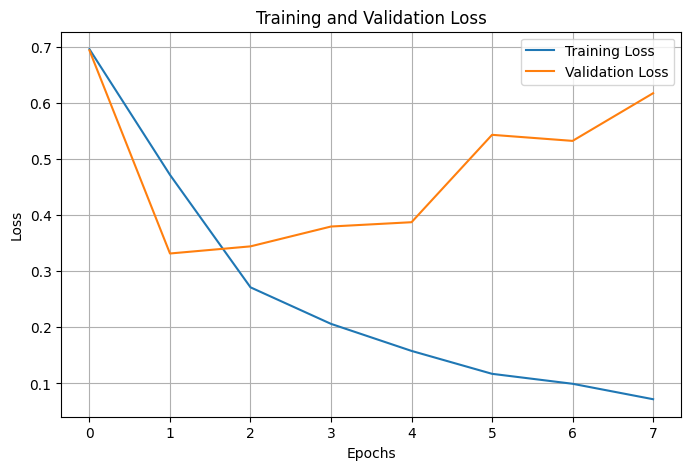

In [15]:
import matplotlib.pyplot as plt

hist = history.history

# Training vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#Training vs Validation Loss 
plt.figure(figsize=(8, 5))
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Save in HDF5 format
model.save("Transformer_Sentiment_Model.h5")

# OR save in native Keras format
model.save("Transformer_Sentiment_Model.keras")

# Load the model
loaded_model = tf.keras.models.load_model(
    "Transformer_Sentiment_Model.h5",
    custom_objects={
        "Encoder": Encoder,
        "EncoderBlock": EncoderBlock,
        "MultiHeadAttention": MultiHeadAttention,
        "PositionalEncoding": PositionalEncoding
    }
)

print("\nModel loaded successfully!")
loaded_model.summary()



Model loaded successfully!
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 encoder (Encoder)           (None, 128, 64)           1346944   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                 

157/157 [==============================] - 1s 5ms/step


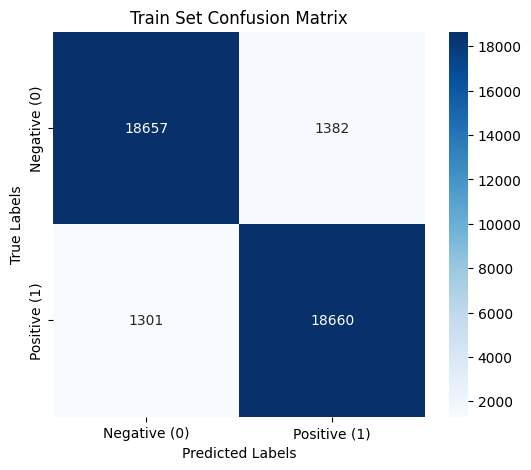


--- Train Set Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.93      0.93      0.93     20039
Positive (1)       0.93      0.93      0.93     19961

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000



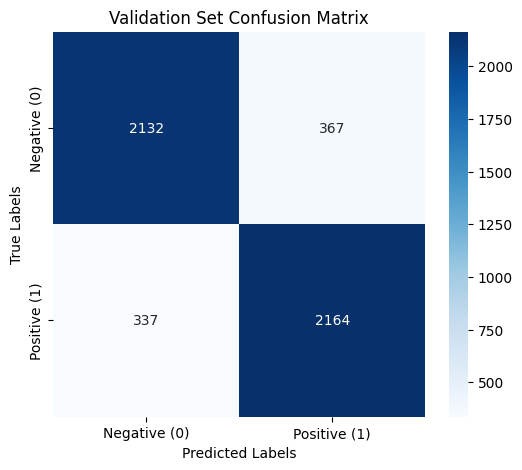


--- Validation Set Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.86      0.85      0.86      2499
Positive (1)       0.85      0.87      0.86      2501

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



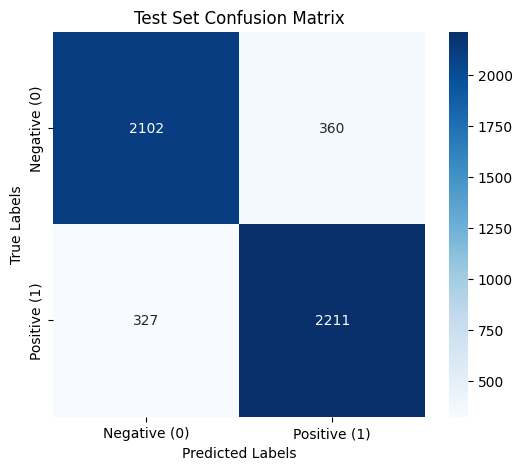


--- Test Set Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.87      0.85      0.86      2462
Positive (1)       0.86      0.87      0.87      2538

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_heatmap(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    classes = ['Negative (0)', 'Positive (1)']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=classes))

# Get predictions
y_train_pred = (loaded_model.predict(X_train_pad) > 0.5).astype(int).flatten()
y_val_pred   = (loaded_model.predict(X_val_pad) > 0.5).astype(int).flatten()
y_test_pred  = (loaded_model.predict(X_test_pad) > 0.5).astype(int).flatten()

# Plot confusion matrices
plot_confusion_heatmap(y_train, y_train_pred, "Train Set")
plot_confusion_heatmap(y_val, y_val_pred, "Validation Set")
plot_confusion_heatmap(y_test, y_test_pred, "Test Set")